## Prepare ERA5-Land 2 m air temperature data

In this notebook, monthly averaged ERA5-Land 2 m air temperature data from 1981 - 2025 is processed. 
The following steps are included:
- Convert data from Kelvin to Degrees Celsius
- Crop data to Germany
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests

In [1]:
# import libraries
import os
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import odc.stac
import rasterio
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# open dataset
era5 = xr.open_dataset("./Raw/ERA5-Land/data_1.nc", decode_coords="all",decode_times=True)

In [5]:
era5

<xarray.Dataset> Size: 52MB
Dimensions:     (valid_time: 528, latitude: 83, longitude: 98)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1981-01-01 ... 2024-12-01
  * latitude    (latitude) float64 664B 55.2 55.1 55.0 54.9 ... 47.2 47.1 47.0
  * longitude   (longitude) float64 784B 5.45 5.55 5.65 ... 14.95 15.05 15.15
    expver      (valid_time) <U4 8kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 17MB ...
    v10         (valid_time, latitude, longitude) float32 17MB ...
    t2m         (valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
# rename dimensions to fit other data
era5 = era5.rename({"valid_time":"time",
                            "longitude": "lon",
                            "latitude": "lat"})

In [7]:
# extract temperature data
t2m = era5.drop_vars(["number", "expver", "u10", "v10"])
t2m

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 528, lat: 83, lon: 98)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
  * lat      (lat) float64 664B 55.2 55.1 55.0 54.9 54.8 ... 47.3 47.2 47.1 47.0
  * lon      (lon) float64 784B 5.45 5.55 5.65 5.75 ... 14.85 14.95 15.05 15.15
Data variables:
    t2m      (time, lat, lon) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [8]:
t2m.t2m.attrs

{'GRIB_paramId': np.int64(167),
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': np.int64(8134),
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': np.int64(1),
 'GRIB_stepType': 'avgid',
 'GRIB_gridType': 'regular_ll',
 'GRIB_uvRelativeToGrid': np.int64(0),
 'GRIB_NV': np.int64(0),
 'GRIB_Nx': np.int64(98),
 'GRIB_Ny': np.int64(83),
 'GRIB_cfName': 'unknown',
 'GRIB_cfVarName': 't2m',
 'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid',
 'GRIB_iDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_iScansNegatively': np.int64(0),
 'GRIB_jDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_jPointsAreConsecutive': np.int64(0),
 'GRIB_jScansPositively': np.int64(0),
 'GRIB_latitudeOfFirstGridPointInDegrees': np.float64(55.2),
 'GRIB_latitudeOfLastGridPointInDegrees': np.float64(47.0),
 'GRIB_longitudeOfFirstGridPointInDegrees': np.float64(5.45),
 'GRIB_longitudeOfLastGridPointInDegrees': np.float64(15.15),
 'GRIB_missingValue': np.float64(3.4028234663852886e+38),
 'GRIB_name': '

In [9]:
# convert temperature from K to °C
t2m['t2m'] = t2m.t2m - 273.15

In [10]:
# change unit in variable attributes
t2m.t2m.attrs["units"] = "C"

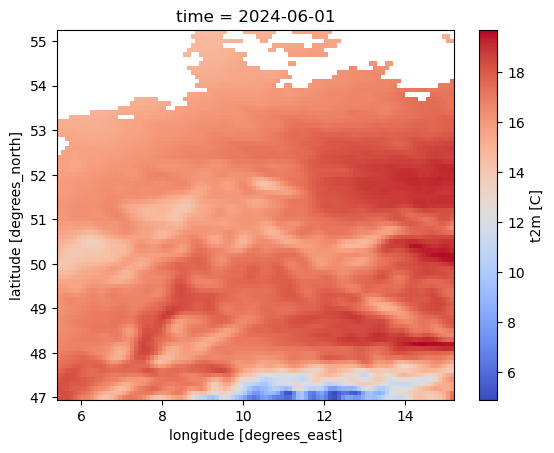

In [11]:
# plot exemplary data of one month to get a first impression
t2m.t2m.sel(time='2024-06-01').plot(cmap='coolwarm')

In [12]:
# check crs
t2m.rio.crs

In [13]:
# assign crs to data
t2m = t2m.rio.write_crs('WGS 1984')

In [14]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [15]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# extract one date to create mask of germany with dimensions of climate data
t2m_ex = t2m.sel(time = "1981-08-01", method = "nearest")

In [17]:
# create mask of research area using the dimensions of the exemplary climate data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=t2m_ex.odc.geobox.shape,
                                            transform=t2m_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [18]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [19]:
# create loop to process temperature data per year
for year in range(1981, 2025):
    
    # select all monthly data within this year
    t2m_yearly = t2m.sel(time = t2m.time.dt.year.isin(year))

    # apply mask of research area to dataset
    t2m_ger = t2m_yearly["t2m"].where(~ger_mask)

    # load forest area from ESA Landcover data for corresponding year
    # attention: forest data only available for 1992 - 2022 -> choose 1992 for climate data of 1988-1992
    # and 2022 for climate data of 2022-2024
    if year <= 1992:
        forest_year = 1992
    elif year >= 2022:
        forest_year = 2022
    else: forest_year = year

    forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)
    
    # set crs for climate data 
    t2m_ger.rio.write_crs(4326, inplace = True)
    
    # set spatial dims - otherwise resampling raises an error
    t2m_ger.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

    # resample climate dataset to match resolution of forest dataset
    t2m_match = t2m_ger.rio.reproject_match(forest)

    # rename dimensions - they got renamed while resampling
    t2m_match = t2m_match.rename({'y':'lat', 'x':'lon'})

    # mask with forest data
    # broadleaved forest:
    t2m_BL = t2m_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

    # needleleaved forest:
    NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
    t2m_NL = t2m_match.where(NL_mask, drop = False)

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    t2m_BL.encoding.update(comp)
    t2m_NL.encoding.update(comp)

    # save as netCDF4 datasets
    t2m_BL.to_netcdf(f"./Climate/Temperature/Monthly/t2m_mon_mean_{year}_BL.nc")
    t2m_NL.to_netcdf(f"./Climate/Temperature/Monthly/t2m_mon_mean_{year}_NL.nc")


In [20]:
# load one processed dataset as example and plot to get an overview
t2m_NL = xr.open_dataarray("./Climate/Temperature/Monthly/t2m_mon_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
t2m_NL

<xarray.DataArray 't2m' (time: 12, lat: 2952, lon: 3510)> Size: 497MB
[124338240 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
Attributes:
    units:    C

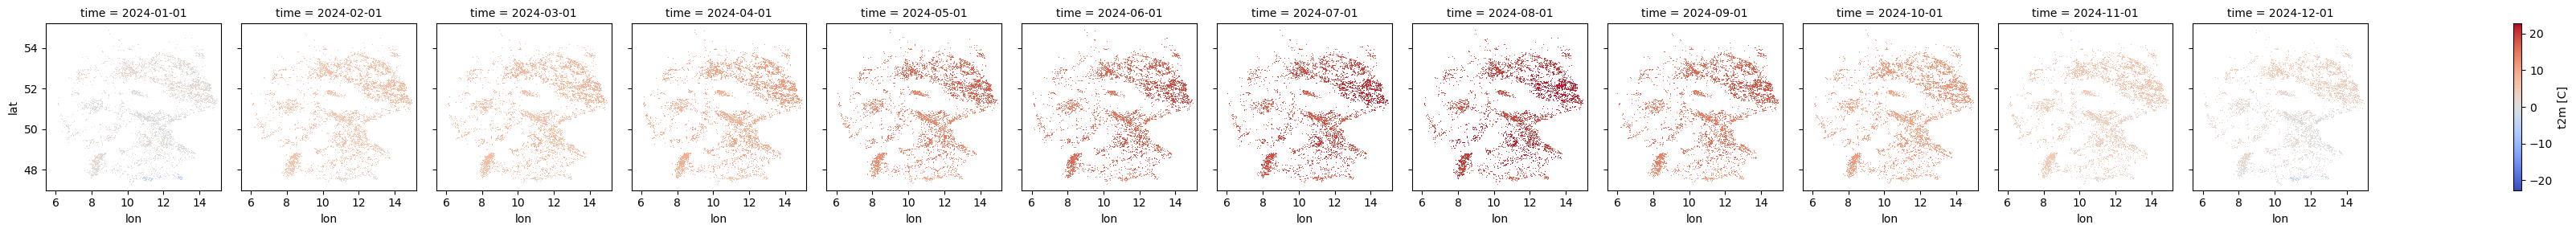

In [21]:
t2m_NL.sel(time = slice('2024-01', '2024-12')).plot(col="time", cmap='coolwarm')